# 库导入

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn
import talib as ta

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# 回测结果评价函数

In [5]:
### 分析函数 - 计算各类指标
def Indicator(equity_df,strategy_name):
    '''
    输入净值序列，一列净值，index为日期；策略名称
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    trade_len = (equity_df.index[-1] - equity_df.index[0]).days
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = (cum_return+1)**(365.25/trade_len)-1
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-0.03)/vol_return
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:strategy_name})
    # 最大回撤结束、开始时间，持续时长
    max_drawdown_end = df['drawdown'].idxmax()
    max_drawdown_end_str = max_drawdown_end.strftime('%Y-%m-%d')
    df_before_max_drawdowm = df[df.index<=max_drawdown_end].copy()
    max_drawdown_start = df_before_max_drawdowm[df_before_max_drawdowm['drawdown'] == 0].index[-1]
    max_drawdown_start_str = max_drawdown_start.strftime('%Y-%m-%d')
    max_drawdown_year = (max_drawdown_end - max_drawdown_start).days/365.25

    output_dict = {
                   '年化收益':[mean_return],
                   '年化波动':[vol_return],
                   'IR':[IR],
                   '夏普比率':[sharpe_ratio],
                   '最大回撤':[max_drawdown],
                   '收益回撤比':[mean_return_max_drawdown_ratio],
                   '最大回撤开始':[max_drawdown_start_str],
                   '最大回撤结束':[max_drawdown_end_str],
                   '最大回撤持续':[max_drawdown_year],
                  }
    output_df = pd.DataFrame(output_dict,index=[strategy_name]).T
    return output_df, df, df_return_per_year

# 沪深300 - 技术指标策略 MA、MACD、RSI、SAR等

## 数据导入

In [6]:
###################### 初始化设定 - 品种+日期&收盘价序列 ######################
## 数据导入 ##
PriceData_ = pd.read_excel('C:/Users/Thinkpad/Desktop/东吴金工实习总文件夹/高老师均线策略数据库/均线策略数据库-四类价格.xlsx')
## 起止时间点 ##
start = '2005-01-01'
end = '2019-07-31'
PriceData = PriceData_[(PriceData_['日期']>=start) & (PriceData_['日期']<=end)]
## 品种选择 ##
KIND = '沪深300'

## 技术指标计算

In [7]:
###################### MA系列 ######################
def MAsignal(PriceData, KIND = '沪深300'):
    '''
    PriceData, pandas.DataFrame, colnames：['品种','日期','收盘价','开盘价','最高价','最低价'],
    '''
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['MA%s'%(LongWind)] = DataForKIND['收盘价'].rolling(LongWind).mean()
    DataForKIND['MA%s'%(ShortWind)] = DataForKIND['收盘价'].rolling(ShortWind).mean()
    DataForKIND['MA%s_MA%s'%(ShortWind,LongWind)] = DataForKIND['MA%s'%(ShortWind)]-DataForKIND['MA%s'%(LongWind)]
    DataForKIND['MA%s_MA%s_signal'%(ShortWind,LongWind)] \
    = DataForKIND['MA%s_MA%s'%(ShortWind,LongWind)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
    return DataForKIND

In [8]:
###################### MACD系列 ######################
def MACDsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['DI'] = DataForKIND['最高价']*0.25 + DataForKIND['最低价']*0.25 + DataForKIND['收盘价']*0.5
    ### 算法1 ###
#     DataForKIND['EMA%d'%(FastWind)] = DataForKIND['DI'].ewm(span=FastWind,adjust=False,min_periods=FastWind).mean()
#     DataForKIND['EMA%d'%(SlowWind)] = DataForKIND['DI'].ewm(span=SlowWind,adjust=False,min_periods=SlowWind).mean()
#     DataForKIND['DIF'] = DataForKIND['EMA%d'%(FastWind)] - DataForKIND['EMA%d'%(SlowWind)]
#     DataForKIND['MACD'] = DataForKIND['DIF'].ewm(span=SignalWind,adjust=False,min_periods=SignalWind).mean()
    ### 算法2 ###
    DataForKIND['DIF'] = ta.MACD(DataForKIND['DI'],FastWind,SlowWind,SignalWind)[0]
    DataForKIND['MACD'] = ta.MACD(DataForKIND['DI'],FastWind,SlowWind,SignalWind)[1]
    
    DataForKIND['DminusF_F%dS%dSig%d'%(FastWind,SlowWind,SignalWind)] = DataForKIND['DIF'] - DataForKIND['MACD']
    DataForKIND['DminusF_F%d_S%d_Sig%d_signal'%(FastWind,SlowWind,SignalWind)] \
    = DataForKIND['DminusF_F%dS%dSig%d'%(FastWind,SlowWind,SignalWind)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
    return DataForKIND

In [9]:
###################### RSI系列 ######################
def RSIsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['RSI_%d'%(ShortRsiWind)] = ta.RSI(DataForKIND['收盘价'], timeperiod=ShortRsiWind)
    DataForKIND['RSI_%d'%(LongRsiWind)] = ta.RSI(DataForKIND['收盘价'], timeperiod=LongRsiWind)
    DataForKIND['dRSI_%d_%d'%(ShortRsiWind,LongRsiWind)] \
    = DataForKIND['RSI_%d'%(ShortRsiWind)] - DataForKIND['RSI_%d'%(LongRsiWind)]
    DataForKIND['dRSI_S%d_L%d_signal'%(ShortRsiWind,LongRsiWind)] \
    = DataForKIND['dRSI_%d_%d'%(ShortRsiWind,LongRsiWind)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
    return DataForKIND

In [10]:
###################### SAR系列 ######################
def SARsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    DataForKIND['SAR_AF%.2fto%.1f'%(AF,AF_max)] \
    = ta.SAR(DataForKIND['最高价'], DataForKIND['最低价'], acceleration=AF, maximum=AF_max)
    DataForKIND['close_SAR_AF%.2fto%.1f'%(AF,AF_max)] \
    = DataForKIND['收盘价'] - DataForKIND['SAR_AF%.2fto%.1f'%(AF,AF_max)]
    DataForKIND['SAR_AF%.2fto%.1f_signal'%(AF,AF_max)] \
    = DataForKIND['close_SAR_AF%.2fto%.1f'%(AF,AF_max)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
    return DataForKIND

In [11]:
###################### BBANDS系列 ######################
def BBANDSsignal(PriceData, KIND = '沪深300'):
    ## 可选参数设定 ##
    DataForKIND = PriceData[PriceData['品种'] == KIND].copy()
    ## 指标计算 ##
    BBANDS_result = ta.BBANDS(DataForKIND['收盘价'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=0)
    DataForKIND['BBANDS_UP_W%dD%d'%(timeperiod,nbdev)] = BBANDS_result[0]
    DataForKIND['BBANDS_DN_W%dD%d'%(timeperiod,nbdev)] = BBANDS_result[2]
    DataForKIND['BBANDS_W%dD%d_signal'%(timeperiod,nbdev)] \
    = DataForKIND.apply(lambda x: 1 if x['收盘价']>x['BBANDS_UP_W%dD%d'%(timeperiod,nbdev)] else -1 if x['收盘价']<x['BBANDS_DN_W%dD%d'%(timeperiod,nbdev)] else 0,axis=1)
    return DataForKIND

## 回测框架

In [12]:
###################### 技术指标函数形式统一化 ######################
## 基本信息 ##
def TaFUN(ta):
    FUN = {'MA':MAsignal,
           'MACD':MACDsignal,
           'RSI':RSIsignal,
           'SAR':SARsignal,
           'BBANDS':BBANDSsignal,
          }
    return FUN[ta]

In [13]:
###################### 参数设定+技术指标命名 ######################
## MA ##
(ShortWind,LongWind) = 5, 60
## MACD ##
(FastWind,SlowWind,SignalWind) = 12, 26, 9
## RSI ##
(ShortRsiWind,LongRsiWind) = 6, 24
## SAR ##
(AF,AF_max) = 0.02, 0.2
## BBANDS ##
(timeperiod,nbdev) = 10, 2

INDICATOR_nameDICT = {'MA':   'MA%s_MA%s_signal'%(ShortWind,LongWind),
                      'MACD': 'DminusF_F%d_S%d_Sig%d_signal'%(FastWind,SlowWind,SignalWind),
                      'RSI':  'dRSI_S%d_L%d_signal'%(ShortRsiWind,LongRsiWind),
                      'SAR':  'SAR_AF%.2fto%.1f_signal'%(AF,AF_max),
                      'BBANDS': 'BBANDS_W%dD%d_signal'%(timeperiod,nbdev),
                     }

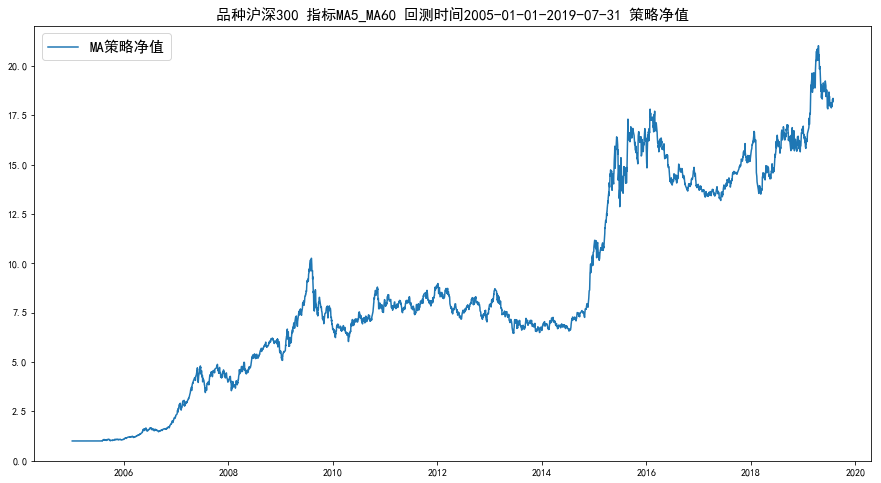

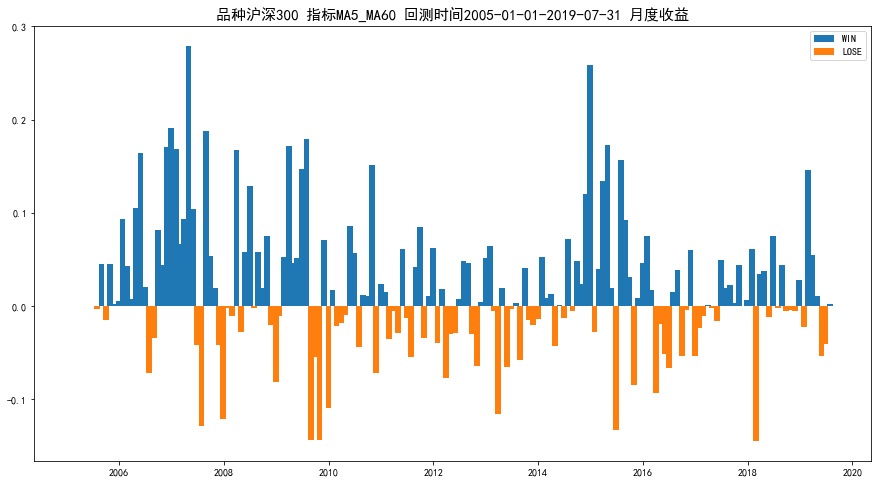

       品种沪深300 指标MA5_MA60
多空切换频率           0.023991
年化收益             0.220355
年化波动             0.240013
IR               0.918097
夏普比率             0.793103
最大回撤             0.411183
收益回撤比            0.535904
最大回撤开始         2009-08-03
最大回撤结束         2010-04-20
最大回撤持续           0.711841





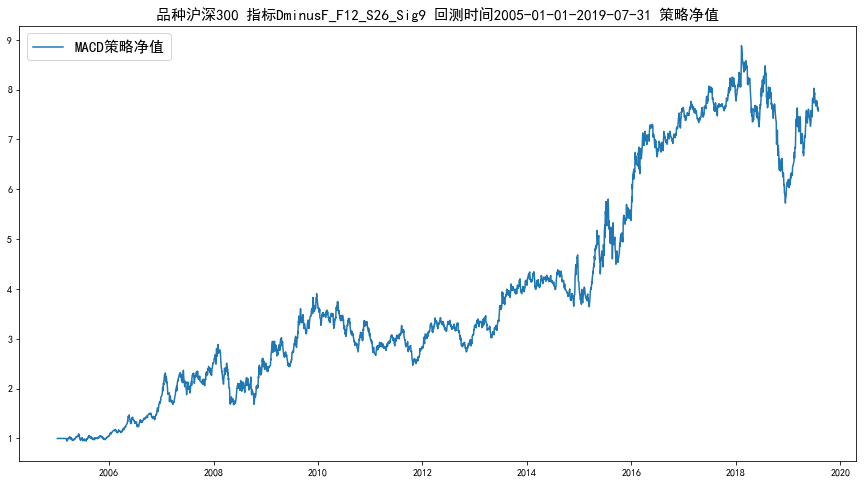

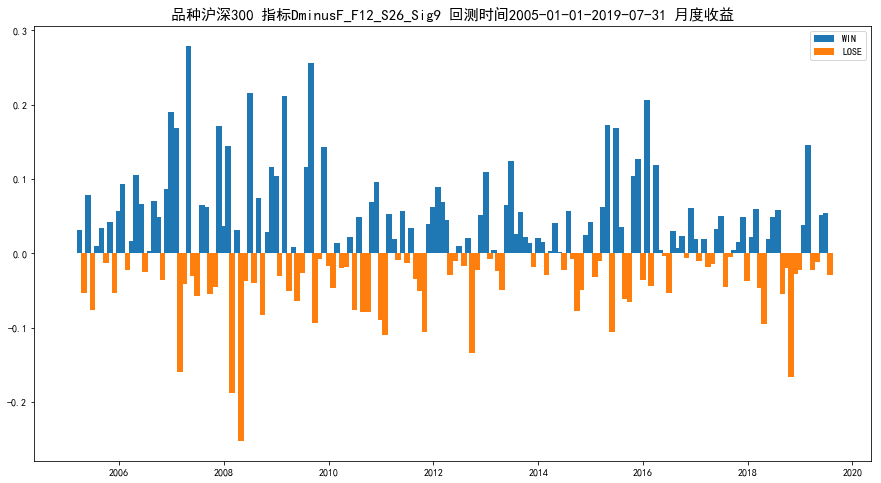

       品种沪深300 指标DminusF_F12_S26_Sig9
多空切换频率                      0.0677392
年化收益                         0.149075
年化波动                         0.260891
IR                           0.571406
夏普比率                         0.456416
最大回撤                         0.418042
收益回撤比                        0.356603
最大回撤开始                     2008-02-01
最大回撤结束                     2008-05-20
最大回撤持续                       0.298426





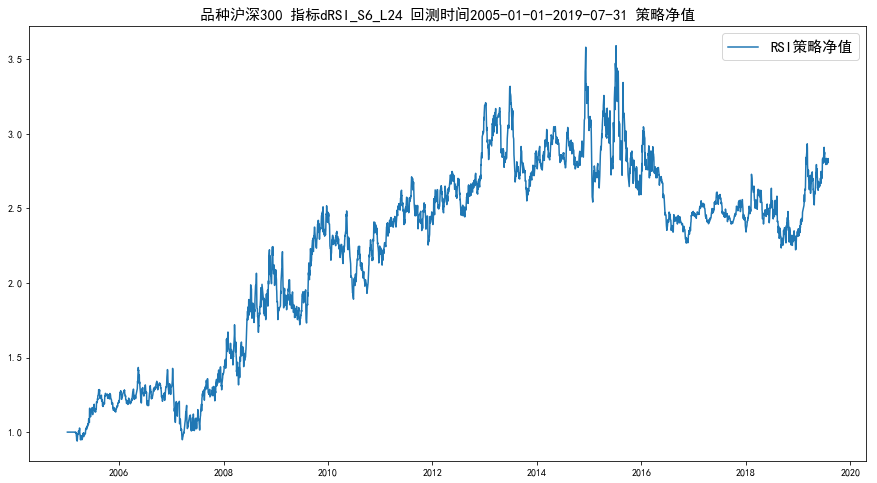

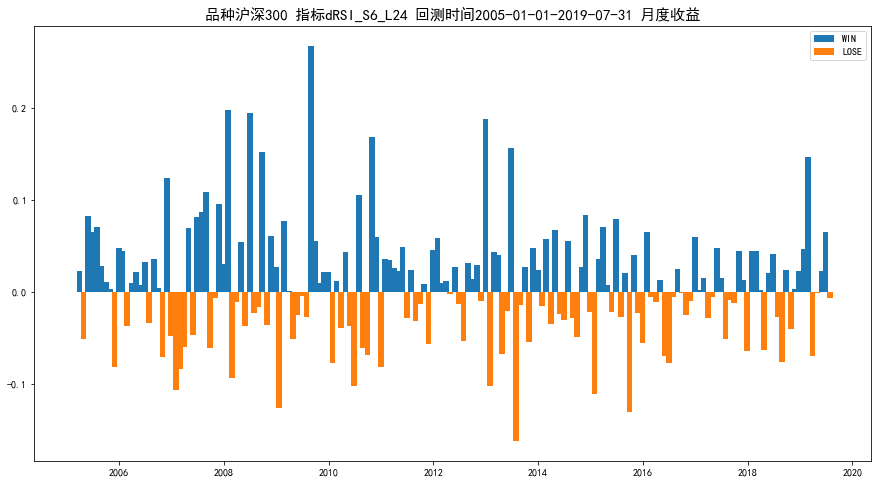

       品种沪深300 指标dRSI_S6_L24
多空切换频率              0.178662
年化收益               0.0734466
年化波动                0.262024
IR                  0.280305
夏普比率                0.165811
最大回撤                0.381034
收益回撤比               0.192756
最大回撤开始            2015-07-08
最大回撤结束            2018-12-14
最大回撤持续                 3.436





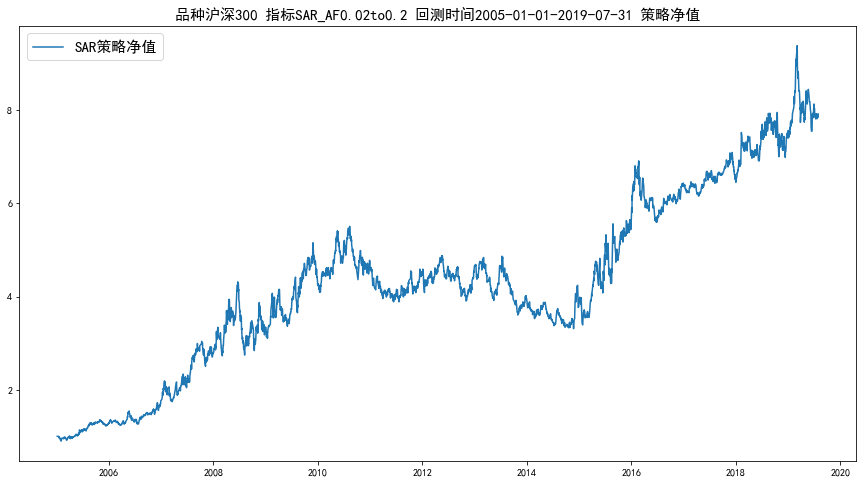

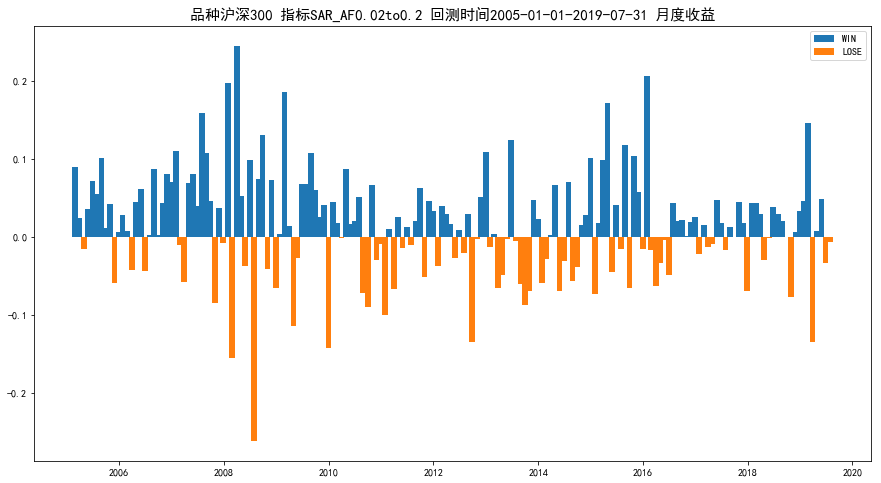

       品种沪深300 指标SAR_AF0.02to0.2
多空切换频率                 0.0894722
年化收益                    0.151968
年化波动                    0.262365
IR                      0.579224
夏普比率                    0.464879
最大回撤                     0.39891
收益回撤比                   0.380958
最大回撤开始                2010-08-11
最大回撤结束                2014-11-24
最大回撤持续                   4.28747





In [19]:
###################### 技术指标选择并回测 ######################
KIND = '沪深300'
Indicator_Dict = {}
for taKIND in ['MA','MACD','RSI','SAR']:
# for taKIND in ['MA','MACD','RSI','SAR','BBANDS']:
    INDICATOR_used = taKIND
    
    ######################## 回测 ########################
    ###################### 指标转换接入回测 ######################
    DataForKIND = TaFUN(INDICATOR_used)(PriceData)
    INDICATOR = INDICATOR_nameDICT[INDICATOR_used]
    DataForKIND_S = DataForKIND.copy()
    DataForKIND_S['Signal'] = DataForKIND_S[INDICATOR]
    DataForKIND_S['dprice'] = DataForKIND_S['收盘价']-DataForKIND_S['收盘价'].shift(1)
    DataForKIND_S['change'] = (DataForKIND_S['Signal'] - DataForKIND_S['Signal'].shift(1)).apply(lambda x: 1 if x>0 else 1 if x<0 else x)
    ###################### 储存各类信息 ######################
    dateList = DataForKIND_S['日期'].tolist()
    priceList = DataForKIND_S['收盘价'].tolist()
    combineList = DataForKIND_S['Signal'].tolist()
    changeList = DataForKIND_S['change'].tolist()
    dpriceList = DataForKIND_S['dprice'].tolist()
    ####################### 初始化状态 ######################
    equity = 1
    Nshare = 0
    L = 0
    equityList = []
    ####################### 日循环执行策略 ######################
    strategy_name = ('品种%s 指标%s'%(KIND,INDICATOR))[:-7]
    for dateCnt in range(len(dateList)):
        ## 更新每日信息
        date = dateList[dateCnt]
        date_last = dateList[dateCnt-1]
        price = priceList[dateCnt]
        dprice = dpriceList[dateCnt]
        combine = combineList[dateCnt]
        change = changeList[dateCnt]
        ## 先结算 - 由于信息每日收盘才能得到！
        dequity = Nshare*dprice*L
        if np.isnan(dequity):
            dequity = 0
        equity += dequity
        equityList.append(equity)
        ## 再根据收盘时发出的信号决定是否改变仓位
        if change == 1:
            L = combine
            Nshare = equity/price
    ####################### 回测结果保存 ######################
    equityDf_KIND = pd.DataFrame({'日期':dateList,strategy_name:equityList}).set_index('日期')
    DataForKIND_S_withResult = DataForKIND_S.merge(pd.DataFrame({'日期':dateList,strategy_name:equityList}),on=['日期'])
    ####################### 结果输出 ######################
    ## 净值曲线 ##
    plt.figure(figsize=(15,8))
    plt.plot(equityDf_KIND,label='%s策略净值' %(INDICATOR_used))
    plt.title('%s 回测时间%s-%s 策略净值' %(strategy_name,start,end),fontsize=15)
    plt.legend(loc=0,fontsize=15)
    plt.show()
    ## 专用指标 ##
    ### 多空切换频率 ##
    LongShortChangeFreq = DataForKIND_S_withResult['change'].sum()/len(DataForKIND_S_withResult)
#     ### 多空区间胜率 ##
#     WinProbDf = DataForKIND_S_withResult[[strategy_name,'change']]
#     WinProbDf_ = WinProbDf[WinProbDf['change'] == 1].pct_change().dropna()
#     WinProb = WinProbDf_[strategy_name].apply(lambda x: 1 if x>0 else 0).sum()/len(WinProb_)
    New_Indicator = pd.DataFrame([LongShortChangeFreq],index=['多空切换频率'],columns=[strategy_name])
    ## 月度收益 ##
    equityDf_KIND['日期'] = equityDf_KIND.index
    equityDf_KIND_MonR = equityDf_KIND.apply(lambda x: x.resample('M').last()).set_index('日期').pct_change().dropna()
    equityDf_KIND_MonR_win = equityDf_KIND_MonR[equityDf_KIND_MonR[strategy_name]>0]
    equityDf_KIND_MonR_lose = equityDf_KIND_MonR[equityDf_KIND_MonR[strategy_name]<=0]
    plt.figure(figsize=(15,8))
    plt.bar(equityDf_KIND_MonR_win.index,equityDf_KIND_MonR_win[strategy_name],width=40,label='WIN')
    plt.bar(equityDf_KIND_MonR_lose.index,equityDf_KIND_MonR_lose[strategy_name],width=40,label='LOSE')
    plt.title('%s 回测时间%s-%s 月度收益' %(strategy_name,start,end),fontsize=15)
    plt.legend(loc=0)
    plt.show()
    ## 回测结果评价指标 ##
    Ori_Indicator = Indicator(equityDf_KIND,strategy_name)[0]
    Combine_Indicator = pd.concat([New_Indicator,Ori_Indicator],axis=0)
    Indicator_Dict[INDICATOR_used] = Combine_Indicator.rename(columns={strategy_name:'%s策略 评价指标'%(INDICATOR_used)})
    print(Combine_Indicator)
    print('\n\n')
    ## 结果数据导出 ##
#     DataForKIND_S_withResult.to_excel('C:/Users/Thinkpad/Desktop/东吴金工实习总文件夹/高老师均线策略数据库/%s净值曲线.xlsx'%(INDICATOR_used))
#     equityDf_KIND_MonR.to_excel('C:/Users/Thinkpad/Desktop/东吴金工实习总文件夹/高老师均线策略数据库/%s月度收益.xlsx'%(INDICATOR_used))
#     Combine_Indicator.to_excel('C:/Users/Thinkpad/Desktop/东吴金工实习总文件夹/高老师均线策略数据库/%s评价指标.xlsx'%(INDICATOR_used))

In [15]:
['MA','MACD','RSI','SAR']
Indicator_Dict['MA']

,MA策略 评价指标
多空切换频率,0.023991
年化收益,0.220355
年化波动,0.240013
IR,0.918097
夏普比率,0.793103
最大回撤,0.411183
收益回撤比,0.535904
最大回撤开始,2009-08-03
最大回撤结束,2010-04-20
最大回撤持续,0.711841


In [16]:
Indicator_Dict['MACD']

,MACD策略 评价指标
多空切换频率,0.0677392
年化收益,0.149075
年化波动,0.260891
IR,0.571406
夏普比率,0.456416
最大回撤,0.418042
收益回撤比,0.356603
最大回撤开始,2008-02-01
最大回撤结束,2008-05-20
最大回撤持续,0.298426


In [17]:
Indicator_Dict['RSI']

,RSI策略 评价指标
多空切换频率,0.178662
年化收益,0.0734466
年化波动,0.262024
IR,0.280305
夏普比率,0.165811
最大回撤,0.381034
收益回撤比,0.192756
最大回撤开始,2015-07-08
最大回撤结束,2018-12-14
最大回撤持续,3.436


In [18]:
Indicator_Dict['SAR']

,SAR策略 评价指标
多空切换频率,0.0894722
年化收益,0.151968
年化波动,0.262365
IR,0.579224
夏普比率,0.464879
最大回撤,0.39891
收益回撤比,0.380958
最大回撤开始,2010-08-11
最大回撤结束,2014-11-24
最大回撤持续,4.28747
